# YOLOv3 실습

**사전준비**

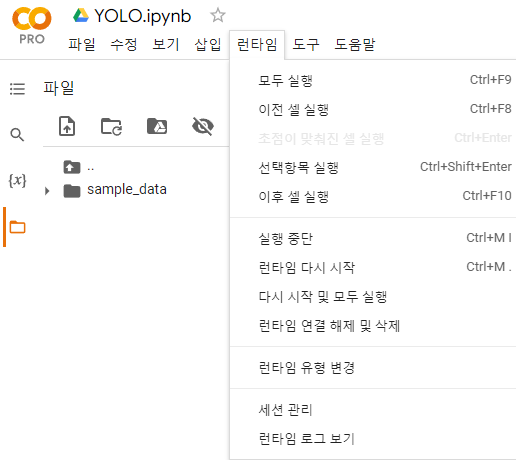
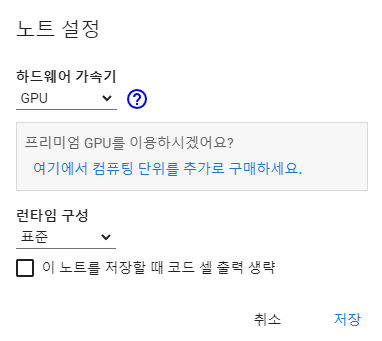

- colab 위쪽의 런타임 탭을 선택
- 런타임 유형 변경 선택
- 하드웨어 가속기를 gpu로 선택 하고 저장

**사용할 패키지 불러오기**

In [ ]:
import pandas as pd 
import numpy as np
import cv2 
import torch 
import os 
import time 
import random
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageDraw
import random
import warnings
from glob import glob 
import cv2
import json
from imageio import imread
from google.colab.patches import cv2_imshow
warnings.filterwarnings('ignore')

&nbsp;

## YOLO v3 car_detection 실습

### 데이터 및 YOLO v3 준비

- yolo v3 준비

In [ ]:
!git clone https://github.com/ultralytics/yolov3
%cd yolov3
!pip install -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 10058, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 10058 (delta 19), reused 28 (delta 13), pack-reused 10017
Receiving objects: 100% (10058/10058), 9.37 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (6777/6777), done.
/content/yolov3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 5.3 MB/s 


- 데이터 준비 ([데이터 정보](https://www.kaggle.com/datasets/sshikamaru/car-object-detection))

In [ ]:
# 위치를 /content로 이동
%cd ..

# Car Object Detection 데이터셋 다운
!gdown https://drive.google.com/uc?id=1l6y0ipjA8FP6Z39GI_X8-7SXCa-vxnG_

# 압축 풀기
!unzip -qq "/content/car_detection.zip"

/content
Downloading...
From: https://drive.google.com/uc?id=1l6y0ipjA8FP6Z39GI_X8-7SXCa-vxnG_
To: /content/car_detection.zip
100% 154M/154M [00:02<00:00, 64.7MB/s]


&nbsp;

### 데이터 확인

- 현재 데이터는 csv 형식
- csv 데이터 안에는 'image', 'xmin', 'ymin', 'xmax', 'ymax'


In [ ]:
data_df = pd.read_csv('./car_detection/car_df.csv')
data_df.head()

image        xmin        ymin        xmax        ymax
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547
1  vid_4_29900.jpg  446.101302  181.655405  527.788712  217.845882
2  vid_4_29900.jpg  284.683068  194.370978  454.905933  266.262870
3  vid_4_29900.jpg   30.816208  200.239704  113.481910  228.116152
4  vid_4_29880.jpg  604.095514  175.297619  676.000000  210.020914

- train : test 수 확인

In [ ]:
train_dir = glob('./car_detection/train/*.jpg')
test_dir = glob('./car_detection/test/*.jpg')

print(f'train 이미지 수 : {len(train_dir)}, test 이미지 수 : {len(test_dir)}')

train 이미지 수 : 300, test 이미지 수 : 100


- 이미지 크기 확인

In [ ]:
# 랜덤한 비복원 추출로 사용할 이미지 5장 선택
ran_name = random.sample(list(data_df.index), k = 5) 
check_image = data_df.iloc[ran_name]['image'] 


im = cv2.imread(f'./car_detection/train/{check_image.iloc[0]}') 
h, w, c = im.shape
print(f'width : {w}, height : {h}, channel : {c}')

width : 676, height : 380, channel : 3


- 이미지 데이터 확인

  0%|          | 0/5 [00:00<?, ?it/s]

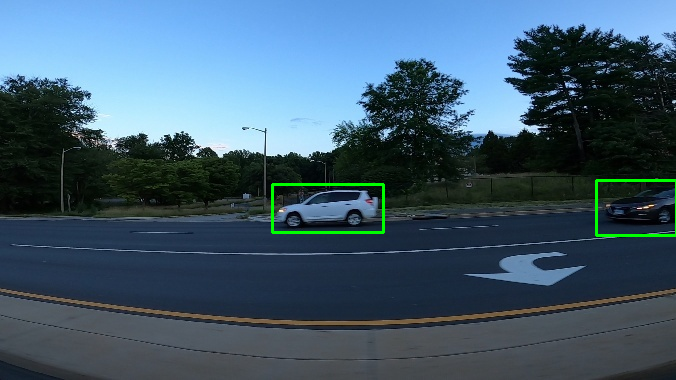

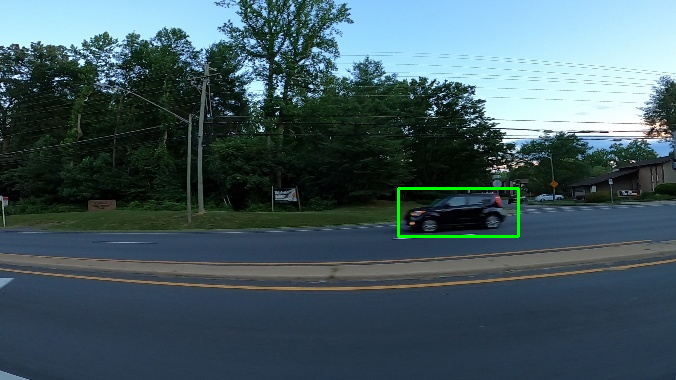

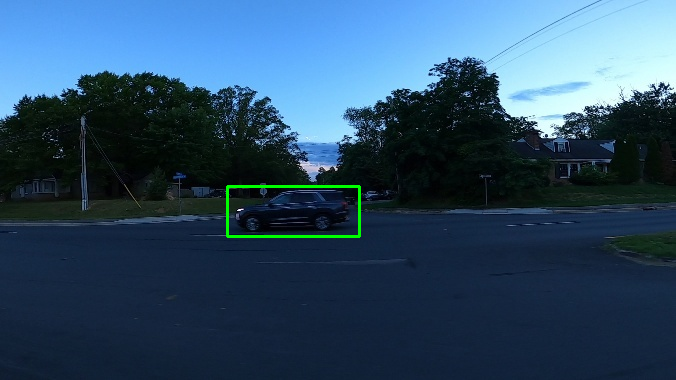

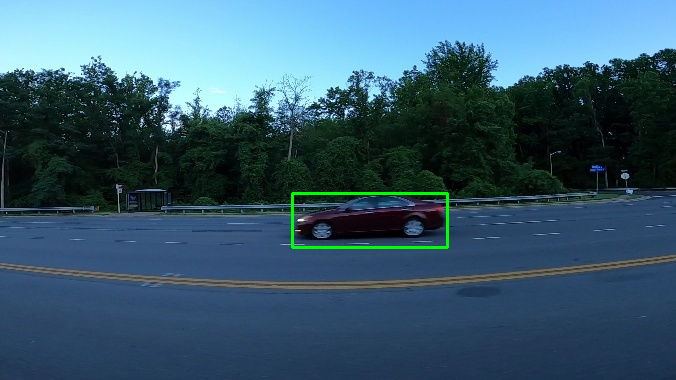

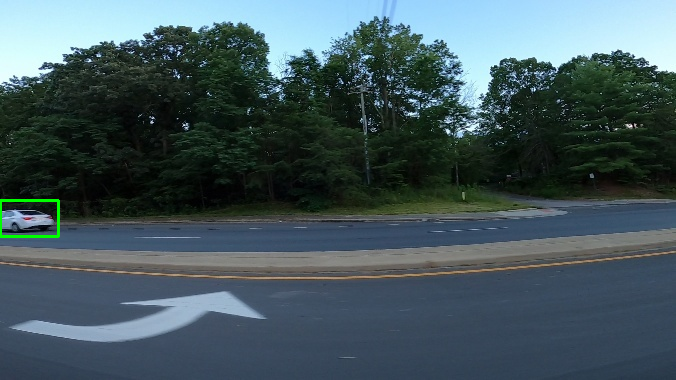

In [ ]:
for i in tqdm(check_image):

    df = data_df.loc[data_df['image'] == i]  # 위에서 선택된 이미지의 dataframe 가져오기
    df.reset_index(drop=True, inplace=True)

    for j in range(len(df)):
        name, xmin, ymin, xmax, ymax = df.iloc[j]['image'], df.iloc[j]['xmin'], df.iloc[j]['ymin'], \
                                       df.iloc[j]['xmax'], df.iloc[j]['ymax']   # 해당 이미지의 정보 가져오기
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax]) # 정수로 변환

        if j == 0:
            img = cv2.imread(f'./car_detection/train/{name}')  # 얻은 정보에서 이미지 불러오기

        cv2.rectangle(img,(xmin, ymin),(xmax,ymax),(0,255,0),2)  # 이미지에 사각형 그리기


    cv2_imshow(img)

### csv데이터 yolov3 format으로 변환

- 'xmin', 'ymin', 'xmax', 'ymax' 데이터를 통해 'x_center', 'y_center', 'w', 'h' 생성

- class는 0 (찾을 객체가 'car' 하나여서)

In [ ]:
img_h, img_w, num_channels = h, w, c # h, w, c 는 위에서 얻은 이미지 크기


# x_center 생성
data_df['x_center'] = (data_df['xmin'] + data_df['xmax'])/2
data_df['x_center'] = data_df['x_center']/img_w

# y_center 생성
data_df['y_center'] = (data_df['ymin'] + data_df['ymax'])/2
data_df['y_center'] = data_df['y_center']/img_h

# width 생성
data_df['w'] = data_df['xmax'] - data_df['xmin']
data_df['w'] = data_df['w']/img_w

# height 생성
data_df['h'] = data_df['ymax'] - data_df['ymin']
data_df['h'] = data_df['h']/img_h

# class 생성
data_df['classes'] = 0

data_df.head()

image        xmin        ymin        xmax        ymax  x_center  \
0   vid_4_1000.jpg  281.259045  187.035071  327.727931  223.225547  0.450434   
1  vid_4_29900.jpg  446.101302  181.655405  527.788712  217.845882  0.720333   
2  vid_4_29900.jpg  284.683068  194.370978  454.905933  266.262870  0.547033   
3  vid_4_29900.jpg   30.816208  200.239704  113.481910  228.116152  0.106729   
4  vid_4_29880.jpg  604.095514  175.297619  676.000000  210.020914  0.946816   

   y_center         w         h  classes  
0  0.539817  0.068741  0.095238        0  
1  0.525660  0.120839  0.095238        0  
2  0.606097  0.251809  0.189189        0  
3  0.563626  0.122287  0.073359        0  
4  0.506998  0.106368  0.091377        0

### yolov3 폴더 형식 및 데이터 분할

 ─────────────────────────────────────────────────────────────    
 📁 yolov3_car_data 


   ├────📃 data.yaml : 데이터의 경로 및 class 내용이 담긴 yaml 파일


   ├──📁 images : tarin,val,test 이미지가 들어있는 폴더


   │    ├──📁 train     


   │    ├──📁 val 


   │    └──📁 test


   │    


   ├──📁 labels : tarin,val label이 들어있는 폴더


   │    ├──📁 train      


   │    └──📁 val 
─────────────────────────────────────────────────────────────      

In [ ]:
# 위의 폴더 형식을 만드는 함수
def make_dir():
    if not os.path.exists('./yolov3_car_data'):
        os.makedirs('./yolov3_car_data')

    if not os.path.exists('./yolov3_car_data/images/'):
        os.makedirs('./yolov3_car_data/images/')

    if not os.path.exists('./yolov3_car_data/labels/'):
        os.makedirs('./yolov3_car_data/labels/')

    for i in ['train','val']:
        if not os.path.exists(f'./yolov3_car_data/images/{i}/'):
            os.makedirs(f'./yolov3_car_data/images/{i}/')
        if not os.path.exists(f'./yolov3_car_data/labels/{i}/'):
            os.makedirs(f'./yolov3_car_data/labels/{i}/')

# 경로 생성
make_dir()

- 이미지 및 라벨 파일 분리 

In [ ]:
# data_df image 중 train : valid 분리
split_data = list(set(list(data_df['image'])))
train_valid_split = random.sample(split_data, k= 210) # 210개는 train : 90개는 val

# 실제 yolo format에 사용되는 class, x_center, y_center, width, height 만 남기기
for name,sep in tqdm(data_df.groupby('image')):
    if name in train_valid_split:
        folder = 'train'
    else:
        folder = 'val'

    with open(f'./yolov3_car_data/labels/{folder}/{name.split(".")[0]}.txt', 'w+') as f:
        row = sep[['classes','x_center','y_center','w','h']].astype(float).values
        row = row.astype(str)
        for j in range(len(row)):
            text = ' '.join(row[j])
            f.write(text)
            f.write("\n")

    sh.copy(f"./car_detection/train/{name}",f'./yolov3_car_data/images/{folder}/{name}')

  0%|          | 0/300 [00:00<?, ?it/s]

- test 데이터 이동

In [ ]:
## test 파일 옯기기
test_imgs = [i.split('/')[-1] for i in glob('./car_detection/test/*.jpg')]

for i in tqdm(test_imgs):

    if not os.path.exists('./yolov3_car_data/images/test/'):
        os.makedirs('./yolov3_car_data/images/test/')

    sh.copy(f"./car_detection/test/{i}", f'./yolov3_car_data/images/test/{i}')

  0%|          | 0/100 [00:00<?, ?it/s]

### yaml 파일 생성

%%writefile (저장할 파일 이름 및 경로)


train : ../yolov3_car_data/images/train (train 이미지 경로)


val : ../yolov3_car_data/images/val (val 이미지 경로)


test: ../yolov3_car_data/images/test (test 이미지 경로)

nc : 1 (class 수)


names: [car] (class 이름)

In [ ]:
%%writefile ./yolov3_car_data/data.yaml
train : ../yolov3_car_data/images/train
val : ../yolov3_car_data/images/val
test: ../yolov3_car_data/images/test

nc : 1
names: [car]

Writing ./yolov3_car_data/data.yaml


### 모델 훈련

--batch : 한번에 훈련시킬 이미지 수 


--epochs : 훈련 횟수

--data : .yaml 경로

--weights : 사용할 모델 가중치, yolov3.py 입력시 자동으로 yolov3 가중치 다운 (연습에서는 사전에 학습시킨 모델 사용)


In [ ]:
os.chdir('./yolov3') # yolov3 폴더로 이동

!python train.py  --batch 16 --epochs 5 --data ../yolov3_car_data/data.yaml --exist-ok --weights ../car_detection/best.pt --cache --device 0

train: weights=../car_detection/best.pt, cfg=, data=../yolov3_car_data/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=0, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=True, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov3 ✅
YOLOv3 🚀 v9.6.0-27-gdd838e2 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, t

* 훈련 결과 출력 맨 아래줄에 **Results saved to** **경로**에 best.pt라는 이름으로 학습 가중치 가운데 validation score가 가장 좋은 결과가 저장됨

* 다음 셀의 --weights 인자에 위 **경로/best.pt**를 입력하여 저장된 가중치를 불러와 추론 수행

In [ ]:
!python ./detect.py --weights ./runs/train/exp/weights/best.pt --conf 0.25 --line-thickness 1 --exist-ok --device 0 --source  ../yolov3_car_data/images/test

detect: weights=['./runs/train/exp/weights/best.pt'], source=../yolov3_car_data/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=True, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv3 🚀 v9.6.0-27-gdd838e2 torch 1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model Summary: 261 layers, 61497430 parameters, 0 gradients, 154.5 GFLOPs
image 1/100 /content/yolov3_car_data/images/test/vid_4_17320.jpg: 384x640 1 car, Done. (0.043s)
image 2/100 /content/yolov3_car_data/images/test/vid_4_17540.jpg: 384x640 2 cars, Done. (0.041s)
image 3/100 /content/yolov3_car_data/images/test/vid_4_17620.jpg: 384x640 2 cars, Done. (0.041s)
image 4/100 /content/yolov3_car_data/images/test/vid_4_21480.jpg: 384x640 2 cars, Done. (0.0

### 모델 결과 시각화

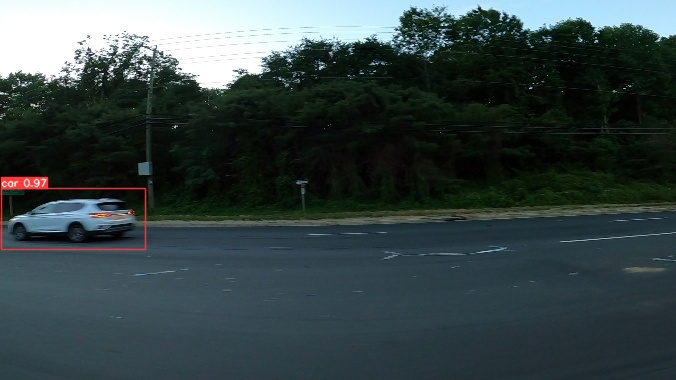

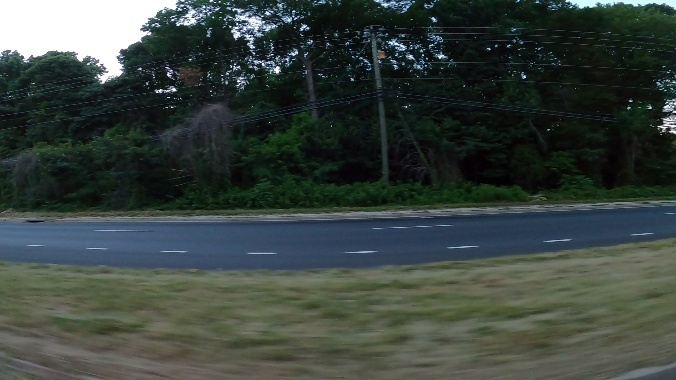

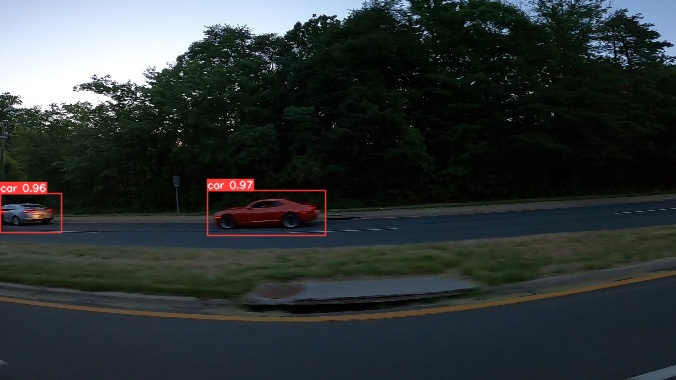

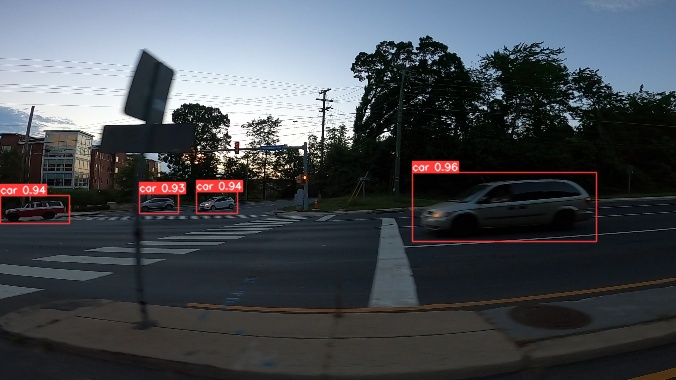

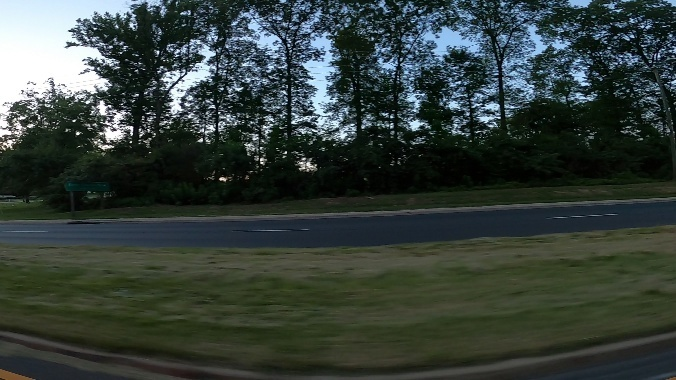

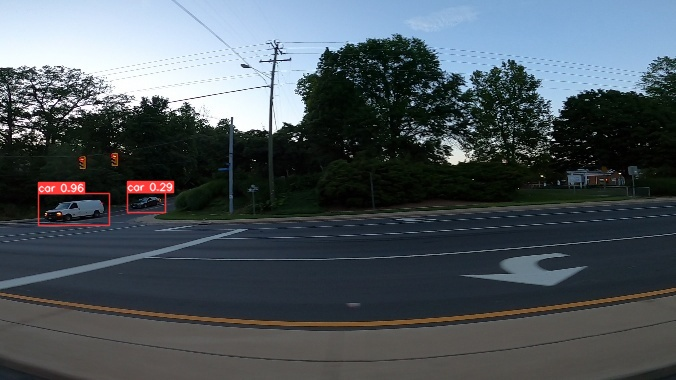

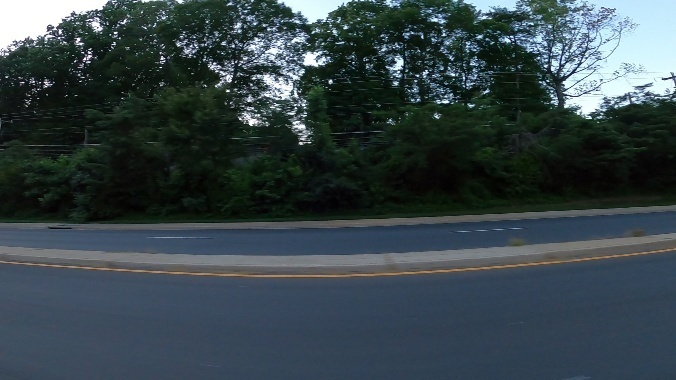

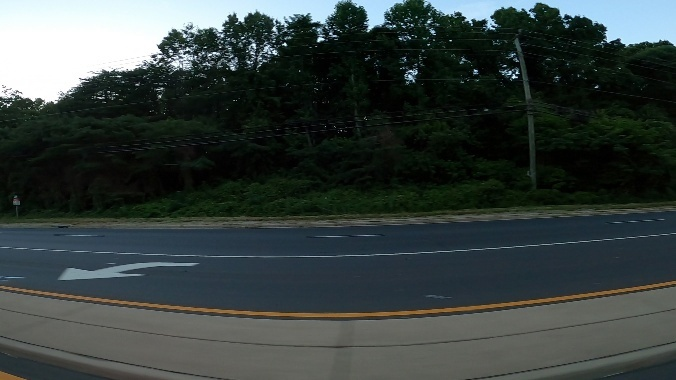

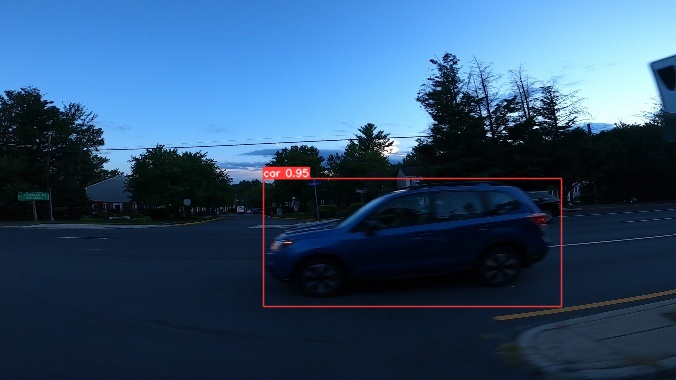

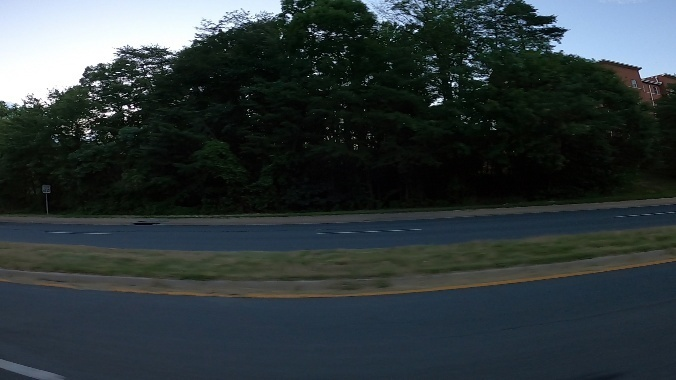

In [ ]:
data_list = glob('./runs/detect/exp/*.jpg')
for i in data_list[:10]:
  src = cv2.imread(i)

  cv2_imshow(src)